In [1]:
import sys
import warnings
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pbmc_helper import load_dex_genes

sys.path.append('..')
sys.path.append('/Users/lciernik/Documents/TUB/projects/ans_scoring/ANS_supplementary_information')
from data.load_data import load_datasets

from score_with_all_methods import (
    score_signatures_with_all_methods,
    label_assignment_from_scores,
    get_lbl_assignment_performance,
    get_information_from_scores,
    remove_overlapping_signature_genes,
    get_violin_all_methods,
    prepare_data_for_violin_plot,
    save_close_or_show,
    plot_confusion_matrix
)

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams.update({'pdf.fonttype': 42, 'font.family': 'sans-serif', 'font.sans-serif': 'Arial', 'font.size': 10})

Storing information and global variables

In [2]:
remove_overlapping_genes = True

SAVE = False
storing_path = Path('/Users/lciernik/Documents/TUB/projects/ans_scoring/results/citeseq/b_subtypes')

if remove_overlapping_genes:
    storing_path = storing_path / 'signatures_without_overlapping'
else:
    storing_path = storing_path / 'signatures_with_overlapping'

if SAVE:
    storing_path.mkdir(parents=True, exist_ok=True)

Loading data

In [3]:
adata = load_datasets('pbmc_b_subtypes')
adata

AnnData object with n_obs × n_vars = 11329 × 11258
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'gene_names', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    layers: 'counts'

In [4]:
y_true_col = 'celltype.l2'
sample_col = 'orig.ident'

In [5]:
adata.obs[y_true_col].value_counts().sort_index()

B intermediate    2033
B memory          2893
B naive           6403
Name: celltype.l2, dtype: int64

Computing dimensionality reduction

In [6]:
# sc.tl.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)

Load signatures

In [7]:
DE_of_celltypes = load_dex_genes(filter_genes=True, threshold_pval=0.01, threshold_log2fc=0.5)

Shape DEX genes BEFORE filtering (11811, 4)
Shape DEX genes AFTER filtering (6288, 4)


In [8]:
subtypes_per_cell_type = adata.obs.groupby('celltype.l2')['celltype.l3'].apply(lambda x: list(x.unique()))

In [9]:
subtypes_per_cell_type.to_dict()

{'B intermediate': ['B intermediate kappa', 'B intermediate lambda'],
 'B memory': ['B memory kappa', 'B memory lambda'],
 'B naive': ['B naive kappa', 'B naive lambda']}

In [10]:
signatures = {}
for row in subtypes_per_cell_type.items():
    cell_type, subtypes = row
    signatures[cell_type] = sorted(
        list(set(DE_of_celltypes[DE_of_celltypes['Cell Type'].isin(subtypes)]['Gene'].tolist())))

In [11]:
for k, v in signatures.items():
    print(k, len(v))

B intermediate 90
B memory 84
B naive 95


In [12]:
if remove_overlapping_genes:
    signatures = remove_overlapping_signature_genes(signatures)

Removed {'CD24', 'ADAM28', 'LINC00926', 'CD22', 'IGLC3', 'RPL8', 'CXXC5', 'IKZF3', 'BTG1', 'SP140', 'P2RX5', 'MEF2C', 'SPIB', 'CCDC50', 'FAM129C', 'RPS11', 'HLA-DQB1', 'MBD4', 'EZR', 'SP110', 'CD37', 'RPS18', 'CD79B', 'HLA-DMA', '1-Mar', 'HLA-DRB1', 'IGKC', 'STX7', 'SP100', 'CD74', 'CD40', 'CYB561A3', 'TSC22D3', 'AIM2', 'PAX5', 'BIRC3', 'IGHM', 'OSBPL10', 'RALGPS2', 'PDLIM1', 'IRF8', 'RPS5', 'HLA-DPA1', 'RPS23', 'VPREB3', 'TNFRSF13C', 'STRBP', 'RPS27', 'IGLC2', 'JCHAIN', 'HLA-DRB5', 'BANK1', 'POU2AF1', 'BCL11A', 'EEF1B2', 'HLA-DQA1', 'JUND', 'SWAP70', 'FCRL5', 'AFF3', 'SNX2', 'TXNIP', 'HLA-DPB1', 'CD82', 'COBLL1', 'LTB', 'CD79A', 'FCMR', 'RPSA', 'MS4A1', 'IGHD', 'TCF4', 'RPL13A', 'HLA-DMB', 'CD52', 'TNFRSF13B', 'BLK', 'HLA-DRA', 'PRKCB'} overlapping genes.
Signature B intermediate length: before=90, after=16
Signature B memory length: before=84, after=19
Signature B naive length: before=95, after=34


In [13]:
order_signatures = ['B naive', 'B intermediate', 'B memory']

Scoring signatures

In [14]:
score_cols, adata = score_signatures_with_all_methods(adata, signatures)

Label assignment

In [15]:
all_cols = []
label_cols = {}
for method_name, method_scores in score_cols.items():
    adata, new_lbl_col = label_assignment_from_scores(adata, method_name, method_scores, include_undefined=False)
    label_cols[method_name] = new_lbl_col
    all_cols += method_scores + [new_lbl_col]

Visualizing results

In [16]:
### UMAP
# fig = sc.pl.umap(adata, color=all_cols + [sample_col, y_true_col, 'celltype.l1', 'celltype.l3'],
#                  ncols=len(signatures) + 1, return_fig=True)
# save_close_or_show(fig, SAVE, storing_path / 'umap.pdf')

In [17]:
df_melted = prepare_data_for_violin_plot(adata, y_true_col, score_cols)

In [18]:
df_melted['Signature'].unique()

array(['B intermediate', 'B memory', 'B naive'], dtype=object)

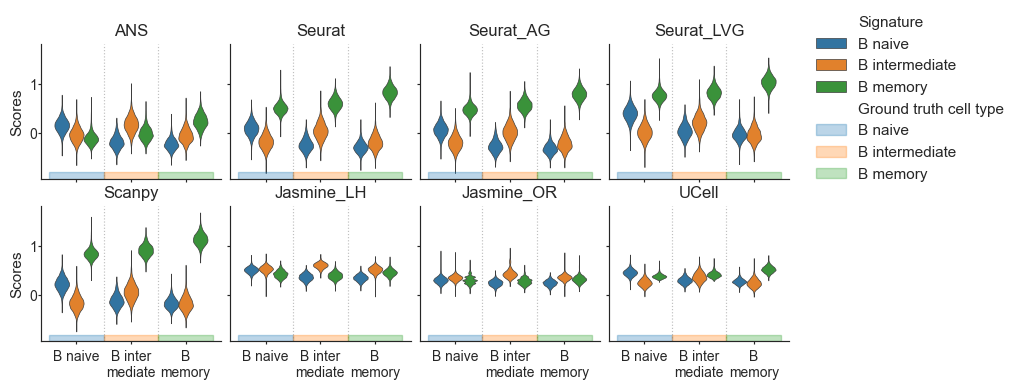

In [19]:
### Combined violin plots
fig = get_violin_all_methods(
    df_melted, 
    y_true_col, 
    hue_order=order_signatures, 
    textwrap_width=7, 
    aspect=1.05, 
    sharey=True,
    legend_bbox_anchor=(1.075, 1),
    fontsizes={'title': 12, 'labels': 11, 'ticks': 10, 'legend': 11}
)
save_close_or_show(fig, SAVE, storing_path / "violin_all_methods.pdf")

In [20]:
### Single violin plots
# for method_name, method_scores in score_cols.items():
#     df = adata.obs.loc[:, method_scores + [y_true_col]]
#     fig = get_violin(df, method_scores, y_true_col)
#     plt.title(f"{method_name}")
#     save_close_or_show(fig, SAVE, storing_path / f'violin_{method_name}.pdf')

Computing label assignment performance

In [ ]:
metrics = defaultdict(dict)
nfold = 10
overall_min = np.inf
overall_max = -np.inf

for method_name, method_scores in score_cols.items():
    lbl_col = label_cols[method_name]
    conf_mat, bal_acc, f1_val = get_lbl_assignment_performance(adata,
                                                               y_true_col=y_true_col,
                                                               y_pred_col=lbl_col,
                                                               label_names=order_signatures)

    scores = get_information_from_scores(adata, y_true_col=y_true_col, scores=method_scores, nfold=nfold)

    metrics[method_name] = {
        'conf_mat': conf_mat,
        'balanced_accuracy': bal_acc,
        'f1_score': f1_val,
        f'logreg_balanced_accuracy_{nfold}cv': np.mean(scores),
        f'logreg_balanced_accuracy_{nfold}cv_std': np.std(scores)
    }

    ## Confusion matrix plot
    # fig = plot_confusion_matrix(conf_mat, order_signatures, method_name, figsize=(2.3, 2.3), textwrap_width=7,
    #                             xrotation=45, cbar=False)
    fig = plot_confusion_matrix(conf_mat, order_signatures, method_name)
    save_close_or_show(fig, SAVE, storing_path / f'conf_mat_{method_name}.pdf')

In [ ]:
metrics_df = pd.DataFrame(metrics)

Saving performance metrics

In [ ]:
if SAVE:
    metrics_df.to_csv(storing_path / 'metrics.csv')
    print(f"Saved metrics to {storing_path / 'metrics.csv'}.")